In [4]:
import numpy as np 
import pandas as pd 
from datetime import datetime
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.model_selection import ParameterGrid
from timeit import default_timer as timer
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = (12,5)
%matplotlib inline
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.statespace.varmax import VARMAX,VARMAXResults
import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

In [5]:
df = pd.read_csv('NVL-Historical-Data.csv', parse_dates=True)
df = df[::-1].reset_index(drop=True)
df['Price'] = df['Price'].str.replace(',', '').astype(float)
df['Open'] = df['Open'].str.replace(',', '').astype(float)
df['High'] = df['High'].str.replace(',', '').astype(float)
df['Low'] = df['Low'].str.replace(',', '').astype(float)
df = df.drop(columns=['Vol.','Change %'])

In [6]:
df

,Date,Price,Open,High,Low
0,01/03/2017,25055.0,25480.0,25480.0,25055.0
1,01/04/2017,25225.0,25055.0,25267.0,25055.0
2,01/05/2017,25097.0,25182.0,25225.0,25055.0
3,01/06/2017,25140.0,25055.0,25140.0,24970.0
4,01/09/2017,25182.0,25097.0,25182.0,24928.0
...,...,...,...,...,...
1795,03/14/2024,16450.0,16650.0,16750.0,16350.0
1796,03/15/2024,16500.0,16450.0,16800.0,16400.0
1797,03/18/2024,16700.0,16500.0,17100.0,16150.0
1798,03/19/2024,16500.0,16900.0,16900.0,16500.0


In [7]:
X = df[['Price', 'Open', 'High', 'Low']]
train = X[:int(0.8*len(X))]
test = X[int(0.8*len(X)):]

train73 = X[:int(0.7*len(X))]
test73 = X[int(0.7*len(X)):]

train91 = X[:int(0.9*len(X))]
test91 = X[int(0.9*len(X)):]

In [8]:
auto_arima(train['Price'],maxiter=100)

ARIMA(maxiter=100, order=(0, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [9]:
auto_arima(train73['Price'],maxiter=100)

ARIMA(maxiter=100, order=(0, 1, 1), scoring_args={}, suppress_warnings=True)

In [10]:
auto_arima(train91['Price'],maxiter=100)

ARIMA(maxiter=100, order=(1, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [11]:
test_model = auto_arima(train['Price'], start_p=1, start_q=1,
                   max_p=5, max_q=5, m=12,
                   start_P=0, seasonal=True,
                   d=1, D=1, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=5.87 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=24243.957, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=23815.028, Time=2.26 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.47 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=24231.736, Time=0.14 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=23686.062, Time=7.77 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=14.13 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.88 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=23707.078, Time=1.65 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=23687.227, Time=8.89 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=inf, Time=17.24 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=23685.341, Time=6.67 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=23815.064, Time=2.04 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=12.68 sec
 ARIMA(0,1,1)(1,1,1)[12]             :

In [13]:
train_transformed = train.diff()

train_transformed73 = train73.diff()

train_transformed91 = train91.diff()

In [30]:
model = VARMAX(train_transformed[['Price', 'Open']], order=(0,1)).fit( disp=False)
model.summary()

C:\Users\luuth\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Dep. Variable:,"['Price', 'Open']",No. Observations:,1440
Model:,VMA(1),Log Likelihood,-22460.467
,+ intercept,AIC,44938.935
Date:,"Sat, 04 May 2024",BIC,44986.386
Time:,19:59:17,HQIC,44956.648
Sample:,0,,
,- 1440,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"nan, nan",Jarque-Bera (JB):,"5341.32, 34206.53"
Prob(Q):,"nan, nan",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"4.62, 8.38",Skew:,"0.51, 0.33"


In [15]:
model73 = VARMAX(train_transformed73[['Price', 'Open']], order=(0,1)).fit( disp=False)
model73.summary()

Dep. Variable:,"['Price', 'Open']",No. Observations:,1260
Model:,VMA(1),Log Likelihood,-19383.572
,+ intercept,AIC,38785.143
Date:,"Sat, 04 May 2024",BIC,38831.393
Time:,19:54:48,HQIC,38802.523
Sample:,0,,
,- 1260,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"nan, nan",Jarque-Bera (JB):,"6141.08, 69592.30"
Prob(Q):,"nan, nan",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"4.06, 6.81",Skew:,"0.42, 2.00"


In [16]:
model91 = VARMAX(train_transformed91[['Price', 'Open']], order=(1,2)).fit( disp=False)
model91.summary()

C:\Users\luuth\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\luuth\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Dep. Variable:,"['Price', 'Open']",No. Observations:,1620
Model:,"VARMA(1,2)",Log Likelihood,-25320.339
,+ intercept,AIC,50674.677
Date:,"Sat, 04 May 2024",BIC,50766.310
Time:,19:56:00,HQIC,50708.682
Sample:,0,,
,- 1620,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"nan, nan",Jarque-Bera (JB):,"5582.17, 26166.72"
Prob(Q):,"nan, nan",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"4.29, 8.84",Skew:,"0.23, 0.03"


In [31]:
predict_transformed = model.forecast(len(test))
temp_df = test.iloc[0] 
selected_cols_first_row = temp_df.loc[['Price', 'Open']]
cumsum = predict_transformed.cumsum()
predict = cumsum + selected_cols_first_row
predict

,Price,Open
1440,74742.813229,76440.621023
1441,74777.875649,76475.703510
1442,74812.938069,76510.785997
1443,74848.000488,76545.868484
1444,74883.062908,76580.950970
...,...,...
1795,87189.972293,88894.903831
1796,87225.034713,88929.986318
1797,87260.097133,88965.068805
1798,87295.159553,89000.151292


In [18]:
predict_transformed73 = model73.forecast(len(test73))
temp_df73 = test73.iloc[0] 
selected_cols_first_row73 = temp_df73.loc[['Price', 'Open']]
cumsum73 = predict_transformed73.cumsum()
predict73 = cumsum73 + selected_cols_first_row73
predict73

,Price,Open
1260,80079.712796,78069.456811
1261,80123.456407,78113.975071
1262,80167.200017,78158.493330
1263,80210.943627,78203.011590
1264,80254.687238,78247.529850
...,...,...
1795,103482.544331,101886.725776
1796,103526.287941,101931.244036
1797,103570.031552,101975.762295
1798,103613.775162,102020.280555


In [19]:
predict_transformed91 = model91.forecast(len(test91))
temp_df91 = test91.iloc[0] 
selected_cols_first_row91 = temp_df91.loc[['Price', 'Open']]
cumsum91 = predict_transformed91.cumsum()
predict91 = cumsum91 + selected_cols_first_row91
predict91

,Price,Open
1620,14541.541722,14937.191730
1621,14514.125543,14945.610197
1622,14492.564545,14917.987442
1623,14468.604054,14896.971881
1624,14444.176020,14873.522332
...,...,...
1795,9415.836450,10050.936740
1796,9386.237064,10022.535466
1797,9356.637678,9994.134192
1798,9327.038292,9965.732918


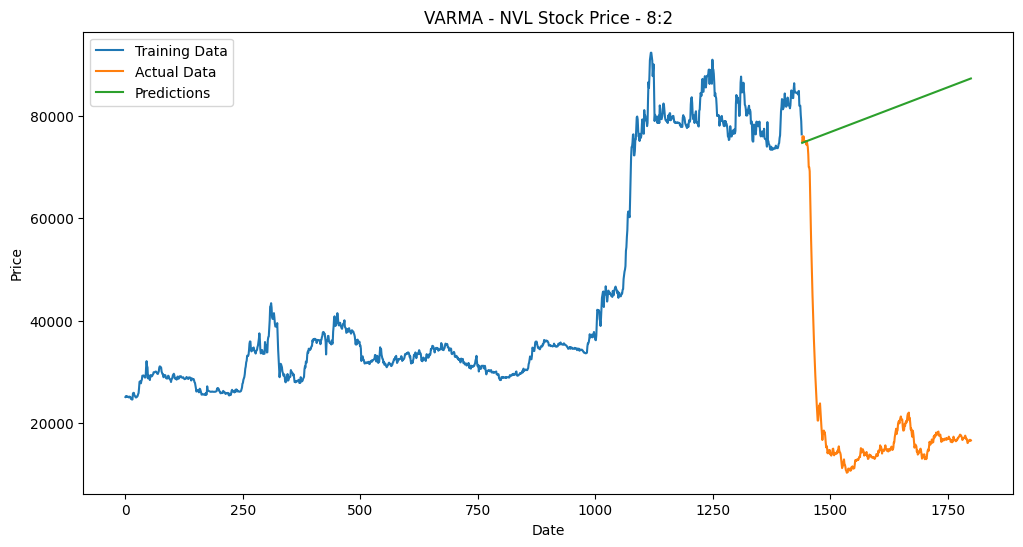

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(train['Price'], label='Training Data')
plt.plot(test['Price'], label='Actual Data')
plt.plot(predict['Price'], label='Predictions')
plt.title('VARMA - NVL Stock Price - 8:2')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

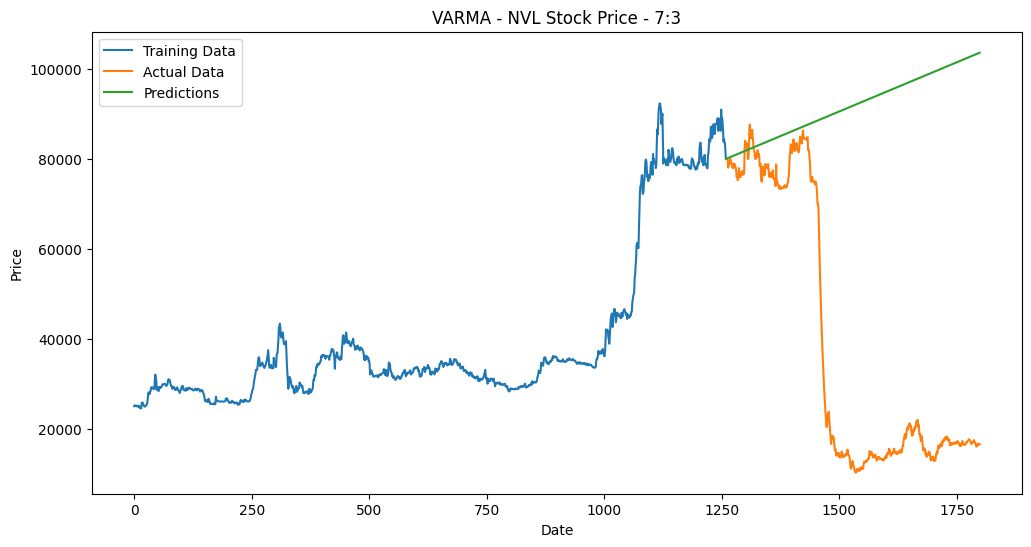

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(train73['Price'], label='Training Data')
plt.plot(test73['Price'], label='Actual Data')
plt.plot(predict73['Price'], label='Predictions')
plt.title('VARMA - NVL Stock Price - 7:3')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

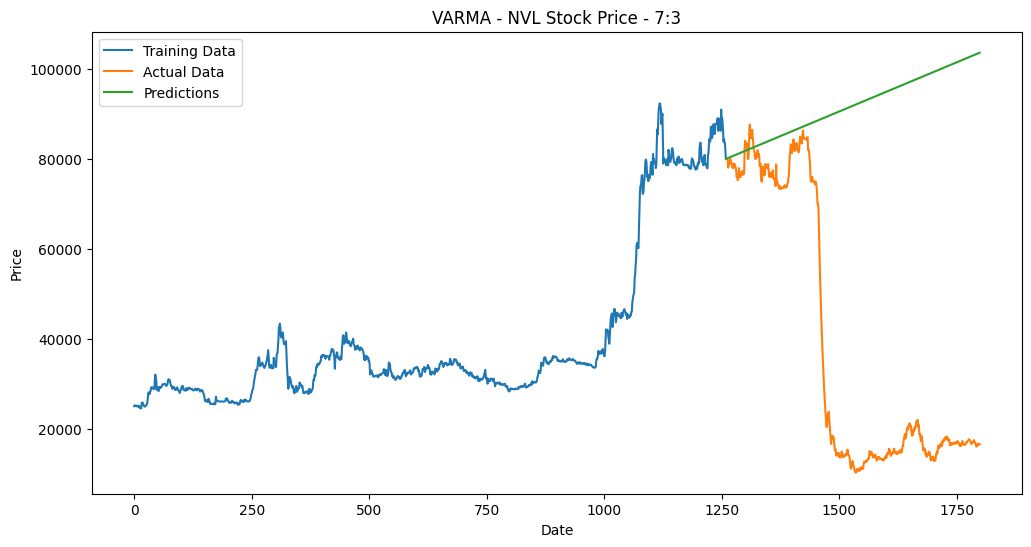

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(train73['Price'], label='Training Data')
plt.plot(test73['Price'], label='Actual Data')
plt.plot(predict73['Price'], label='Predictions')
plt.title('VARMA - NVL Stock Price - 7:3')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [33]:
rmse = np.sqrt(mean_squared_error(test['Price'], predict['Price']))
print("RMSE:", rmse)
mae = mean_absolute_error(test['Price'], predict['Price'])
print("MAE:", mae)
mape = np.mean(np.abs((test['Price'] - predict['Price']) / test['Price'])) * 100
print("MAPE:", mape)

RMSE: 63482.74021724077
MAE: 61596.52174737147
MAPE: 400.39966636578646


In [24]:
rmse = np.sqrt(mean_squared_error(test73['Price'], predict73['Price']))
print("RMSE:", rmse)
mae = mean_absolute_error(test73['Price'], predict73['Price'])
print("MAE:", mae)
mape = np.mean(np.abs((test73['Price'] - predict73['Price']) / test73['Price'])) * 100
print("MAPE:", mape)

RMSE: 63786.8499135354
MAE: 52600.8267205991
MAPE: 329.9603869865021


In [25]:
rmse = np.sqrt(mean_squared_error(test91['Price'], predict91['Price']))
print("RMSE:", rmse)
mae = mean_absolute_error(test91['Price'], predict91['Price'])
print("MAE:", mae)
mape = np.mean(np.abs((test91['Price'] - predict91['Price']) / test91['Price'])) * 100
print("MAPE:", mape)

RMSE: 5448.193086923708
MAE: 4903.271147561997
MAPE: 28.154930164744048
